In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
#https://deeplizard.com/learn/video/oDHpqu52soI

Mounted at /content/gdrive


In [3]:
!cd /content/gdrive/MyDrive/kaggle

In [4]:
#!mkdir /content/gdrive/MyDrive/kaggle/data
#!unzip /content/gdrive/MyDrive/kaggle/aptos2019-blindness-detection.zip -d /content/gdrive/MyDrive/kaggle/data 
!ls /content/gdrive/MyDrive/kaggle/data/

 assets				    model1-1.h5
 graph-model1-1acc.png		    model2
 graph-model1-1loss.png		    model2.h5
 graph-model1-acc.png		    model2-submission.csv
 graph-model1-loss.png		    preview
 graph-model2-acc.png		    sample_submission.csv
 graph-model2-loss.png		    saved_model.pb
 graph-model3-1acc.png		   'submission (1).gsheet'
 graph-model3-1loss.png		    submission.csv
 graph-model3-2acc.png		    submission.gsheet
 graph-model3-2loss.png		    test.csv
 graph-modelvgg16-mar23-1acc.png    test_images
 graph-modelvgg16-mar23-1loss.png   train.csv
 history.json			    train_images
 history-model1-1.csv		    variables
 model1


In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("/content/gdrive/MyDrive/kaggle/data"))
#https://www.kaggle.com/gkcsml1020/aptos-blindness-detection-basic-cnn/edit

['test.csv', 'sample_submission.csv', 'train.csv', 'test_images', 'train_images', 'submission (1).gsheet', 'preview', 'submission.gsheet', 'variables', 'assets', 'saved_model.pb', 'model1', 'graph-model1-acc.png', 'graph-model1-loss.png', 'model2', 'model1-1.h5', 'history.json', 'history-model1-1.csv', 'graph-model1-1acc.png', 'graph-model1-1loss.png', 'submission.csv', 'model2.h5', 'graph-model2-acc.png', 'graph-model2-loss.png', 'model2-submission.csv', 'graph-model3-2acc.png', 'graph-model3-2loss.png', 'graph-model3-1acc.png', 'graph-model3-1loss.png', 'graph-modelvgg16-mar23-1acc.png', 'graph-modelvgg16-mar23-1loss.png']


In [6]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, GaussianNoise, GaussianDropout
from keras.layers import Flatten, BatchNormalization
from keras.layers.convolutional import Conv2D, SeparableConv2D
from keras.constraints import maxnorm
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras import regularizers, optimizers
from keras.optimizers import Adam

In [7]:
train_df = pd.read_csv('/content/gdrive/MyDrive/kaggle/data/train.csv')
train_df['diagnosis'] = train_df['diagnosis'].astype('str')
train_df['id_code'] = train_df['id_code'].astype(str)+'.png'

In [8]:
from keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
    #zca_whitening = True)

batch_size = 16
image_size = 224

train_image_path = '/content/gdrive/MyDrive/kaggle/data/train_images'
test_image_path = '/content/gdrive/MyDrive/kaggle/data/test_images'


train_gen=datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_image_path,
    x_col="id_code",
    y_col="diagnosis",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",
    target_size=(image_size,image_size),
    subset='training')

test_gen=datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_image_path,
    x_col="id_code",
    y_col="diagnosis",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical", 
    target_size=(image_size,image_size),
    subset='validation')


Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.


In [9]:
train_df['id_code'].sample(1)

372    1b495ac025b7.png
Name: id_code, dtype: object

In [10]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
vgg16_model = tf.keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 4s 0us/step


In [11]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [13]:
for layer in model.layers:
    layer.trainable = False

In [14]:
model.add(Dense(units=5, activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [16]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_vgg16 = model.fit(x=train_gen,
          steps_per_epoch=len(train_gen),
          validation_data=test_gen,
          validation_steps=len(test_gen),
          epochs=3,
          verbose=2
)

hist_df = pd.DataFrame(history_vgg16.history) 

hist_csv_file = '/content/gdrive/MyDrive/kaggle/results/history-vgg16-mar23.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)



Epoch 1/3
184/184 - 3205s - loss: 1.2260 - accuracy: 0.5328 - val_loss: 1.1538 - val_accuracy: 0.6434
Epoch 2/3
184/184 - 1968s - loss: 1.0589 - accuracy: 0.6232 - val_loss: 1.0510 - val_accuracy: 0.6284
Epoch 3/3
184/184 - 1979s - loss: 0.9962 - accuracy: 0.6577 - val_loss: 1.0194 - val_accuracy: 0.6079


In [ ]:
history_df = pd.read_csv('/content/gdrive/MyDrive/kaggle/results/history-vgg16-mar23.csv')

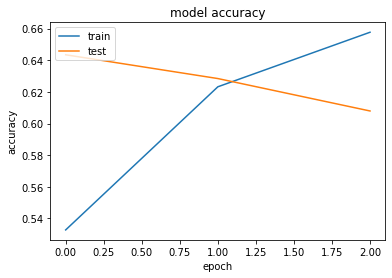

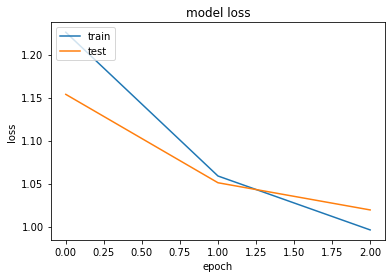

In [ ]:
#plot learning curve 
#https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/
#Reviewing learning curves of models during training can be used to diagnose problems with learning, such as an underfit or overfit model,
# as well as whether the training and validation datasets are suitably representative.
import matplotlib.pyplot as plt
plt.plot(history_df['accuracy'])
plt.plot(history_df['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('/content/gdrive/MyDrive/kaggle/data/graph-modelvgg16-mar23-1acc')
plt.show()
# summarize history for loss
plt.plot(history_df['loss'])
plt.plot(history_df['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('/content/gdrive/MyDrive/kaggle/data/graph-modelvgg16-mar23-1loss')
plt.show()

Learning curves are plots that show changes in learning performance over time in terms of experience.
Learning curves of model performance on the train and validation datasets can be used to diagnose an underfit, overfit, or well-fit model.
Learning curves of model performance can be used to diagnose whether the train or validation datasets are not relatively representative of the problem domain.

Underfit : the model is able to obtain a sufficiently low error  value on the training dataset and has scope for improvement. More epochs can give better answers.


Overfit: measured by performance of the model on the validation set . The plot of training loss decreases over time and the validation loss decreases to a certain point and begins increasing again. The inflection point in the validation plot could be the point where training could be halted.
Again, more epoch can help give better answers.

Good fit : The training and validation loss  does not decrease to a point of stability with a minimal gap between the training and validation plots.
More epochs can help determine good fit. The loss on the training set is less than the loss on the validation set. 

The training and validation datasets were generated from the train dataset and all images are representative examples. We can rule out unrepresentative datasets. 

The conclusion is that we need to train the data on more epochs.
We can
1. consider 5 or 10 epochs 
2. use early stopping on the loss metric and mode checkpoint to save best weights




In [ ]:
from keras.preprocessing.image import load_img
# load an image from file
image = load_img('/content/gdrive/MyDrive/kaggle/data/train_images/0abf0c485f66.png', target_size=(224, 224))

In [ ]:
submission_df = pd.read_csv('/content/gdrive/MyDrive/kaggle/data/sample_submission.csv')
#submission_df['diagnosis'] = submission_df['diagnosis'].astype('str')
submission_df['id_code'] = submission_df['id_code'].astype(str)+'.png'
#test dataset 


sub_image_path = '/content/gdrive/MyDrive/kaggle/data/test_images'
submission_datagen=ImageDataGenerator(rescale=1./255)
submission_gen=submission_datagen.flow_from_dataframe(
    dataframe=submission_df,
    directory=sub_image_path,
    x_col="id_code",    
    batch_size=batch_size,
    shuffle=True,
    class_mode=None,
    target_size=(image_size,image_size))


Found 1928 validated image filenames.


In [ ]:
# predict the probability across all output classes
STEP_SIZE_TEST=submission_gen.n//submission_gen.batch_size
submission_gen.reset()
pred=model.predict_generator(submission_gen,
steps=STEP_SIZE_TEST,
verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


120/120 [==============================] - 824s 7s/step


In [ ]:
predicted_class_indices=np.argmax(pred,axis=1)

In [ ]:
predicted_class_indices.size

1920

In [ ]:
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels
predictions = [labels[k] for k in predicted_class_indices]

In [ ]:
len(predictions)

1920

In [ ]:
#model predicts every image as a 1 

from numpy import array 
filenames = submission_gen.filenames
filenames[0]
print(type(filenames))
filenames = array(filenames)
print(type(filenames))

filenames = filenames[0:1920]



<class 'list'>
<class 'numpy.ndarray'>


In [ ]:
results = pd.DataFrame({'id_code':filenames, 'diagnosis':predictions})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])
results.to_csv('/content/gdrive/MyDrive/kaggle/submission-vgg16.csv',index=False)
results.head(10)

,id_code,diagnosis
0,0005cfc8afb6,1
1,003f0afdcd15,1
2,006efc72b638,1
3,00836aaacf06,1
4,009245722fa4,1
5,009c019a7309,1
6,010d915e229a,1
7,0111b949947e,1
8,01499815e469,1
9,0167076e7089,1


In [31]:
from google.colab import auth
auth.authenticate_user()

In [33]:
CLOUD_PROJECT = 'vgg16_model_308919'
BUCKET = 'gs://' + CLOUD_PROJECT

!gcloud config set project vgg16-model-308919

!gsutil mb $BUCKET
print(BUCKET)



Updated property [core/project].
Creating gs://vgg16_model_308919/...
ServiceException: 409 A Cloud Storage bucket named 'vgg16_model_308919' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.
gs://vgg16_model_308919


In [34]:
model.save(BUCKET, save_format='tf')
#MODEL = 'vgg16mar23'
#!gcloud ai-platform models create $MODEL --regions=us-central1

INFO:tensorflow:Assets written to: gs://vgg16_model_308919/assets


In [40]:
MODEL = 'vgg16_model_308919'
!gcloud ai-platform models create $MODEL --regions=us-central1


Using endpoint [https://ml.googleapis.com/]
Created ai platform model [projects/vgg16-model-308919/models/vgg16_model_308919].


In [37]:
VERSION = 'v1'
MODEL_DIR = BUCKET + '/vgg16_model_308919'

In [ ]:
/content/gdrive/MyDrive/kaggle/data/

Fine tuned a pretrained vgg16 model to predict the class of images 